In [346]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy
import pylab
import math
import random

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from pandas.api.types import is_numeric_dtype
from sklearn.metrics.pairwise import haversine_distances


%matplotlib inline
sns.set()

In [2]:
df = pd.read_excel('Выборка_ектб.xlsx', sheet_name = 0)
df

,ID,Мусор,Агрегатор,LN(Цена),Цена,Цена_перв,Прогноз_1,Прогноз_2,MAE,MAPE,...,Нежилые помещения на первом этаже,строение,Квартира угловая / торцевая,Способ продажи,Отделка,Название новостройки,"Корпус, строение",Тип участия,Срок сдачи,Запланирован снос
0,1_этажи,0,этажи,15.761421,7000000,7200000,7.357429e+06,7.315261e+06,-315260.780670,-0.045037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2_этажи,0,этажи,16.231424,11200000,11400000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3_этажи,0,этажи,15.274126,4300000,4500000,4.955072e+06,4.923574e+06,-623574.436842,-0.145017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4_этажи,0,этажи,15.555977,5700000,6000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5_этажи,0,этажи,14.557448,2100000,2200000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13331,8466_авито,1,авито,15.659230,6320000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,переуступка,NaN,ЖК «Ботаника LIFE»,NaN,другое,Сдан 4 кв. 2023,NaN
13332,8467_авито,0,авито,15.147877,3790000,0,NaN,4.253817e+06,-463816.720736,-0.122379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13333,8468_авито,0,авито,15.054464,3452000,0,NaN,3.777030e+06,-325030.387942,-0.094157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13334,8469_авито,0,авито,15.176487,3900000,0,NaN,3.866094e+06,33905.795052,0.008694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Фильтр объектов

In [3]:
df = df[df['Мусор'] == 0]
df = df[df['Выбросы'] == 0]
df = df[df['dup_res'] == 0]
df = df[df['Многоуровневость'] == 0]
# df = df[df['Терраса'] == 0]
df = df[df['Вид_1'] == 'нет']
df.reset_index(drop = True , inplace = True)
df['Адрес_yandex'] = df['Адрес_yandex'].str.replace(r'Россия, Свердловская область, ', '', regex = True) # Сокращение адреса
df

,ID,Мусор,Агрегатор,LN(Цена),Цена,Цена_перв,Прогноз_1,Прогноз_2,MAE,MAPE,...,Нежилые помещения на первом этаже,строение,Квартира угловая / торцевая,Способ продажи,Отделка,Название новостройки,"Корпус, строение",Тип участия,Срок сдачи,Запланирован снос
0,1_этажи,0,этажи,15.761421,7000000,7200000,7.357429e+06,7.315261e+06,-315260.780670,-0.045037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3_этажи,0,этажи,15.274126,4300000,4500000,4.955072e+06,4.923574e+06,-623574.436842,-0.145017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6_этажи,0,этажи,15.483217,5300000,0,6.115291e+06,6.056768e+06,-756768.110306,-0.142786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7_этажи,0,этажи,15.679591,6450000,6490000,6.246966e+06,6.173033e+06,276967.222331,0.042941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15_этажи,0,этажи,15.823725,7450000,7500000,7.502204e+06,7.472315e+06,-22315.213466,-0.002995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7884,8464_авито,0,авито,15.293700,4385000,0,5.291969e+06,5.297718e+06,-912718.329665,-0.208146,...,NaN,NaN,NaN,NaN,NaN,ЖК «Миллениум»,"Дом 5 (секц. А, Б)",другое,Сдан 2 кв. 2017,NaN
7885,8467_авито,0,авито,15.147877,3790000,0,NaN,4.253817e+06,-463816.720736,-0.122379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7886,8468_авито,0,авито,15.054464,3452000,0,NaN,3.777030e+06,-325030.387942,-0.094157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7887,8469_авито,0,авито,15.176487,3900000,0,NaN,3.866094e+06,33905.795052,0.008694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# list(df.columns)

In [4]:
df_sample = df[[
                'Цена(кв.м)',
                'ОПлощадь',
                'Этаж_1',
                'ГП',
                'Ремонт_1',
                'Районы_2',
                'Сцепка_к',
                'ЖК_БД',
                'Терраса',
                'Адрес_yandex'
              ]]
df_sample

,Цена(кв.м),ОПлощадь,Этаж_1,ГП,Ремонт_1,Районы_2,Сцепка_к,ЖК_БД,Терраса,Адрес_yandex
0,99573.257468,70.30,3,2009.0,стандартный,Академический,60.514731 56.810482,нет,0.0,"Екатеринбург, улица Соболева, 19"
1,106435.643564,40.40,4,1960.0,стандартный,Центральный,60.636515 56.826183,нет,0.0,"Екатеринбург, улица Декабристов, 4"
2,124941.065535,42.42,14,2012.0,стандартный,Пионерский,60.648157 56.864782,нет,0.0,"Екатеринбург, Боровая улица, 31"
3,113556.338028,56.80,4,2014.0,стандартный,Уктус,60.681647 56.782174,нет,0.0,"Екатеринбург, Алтайская улица, 62"
4,168552.036199,44.20,6,2016.0,стандартный,Южный,60.616276 56.804894,нет,0.0,"Екатеринбург, улица Степана Разина, 107Ак2"
...,...,...,...,...,...,...,...,...,...,...
7884,141451.612903,31.00,13,2017.0,стандартный,Юго_Западный,60.572447 56.81096,нет,0.0,"Екатеринбург, улица Громова, 26"
7885,99475.065617,38.10,9,1994.0,стандартный,Уктус,60.649271 56.795727,нет,0.0,"Екатеринбург, Просторная улица, 85"
7886,106543.209877,32.40,9,1994.0,стандартный,Уктус,60.649271 56.795727,нет,0.0,"Екатеринбург, Просторная улица, 85"
7887,118902.439024,32.80,6,1994.0,стандартный,Уктус,60.649271 56.795727,нет,0.0,"Екатеринбург, Просторная улица, 85"


In [5]:
le = LabelEncoder()
df_sample['Районы_2_enc'] = le.fit_transform(df_sample['Районы_2'])
df_sample['Ремонт_1_enc'] = le.fit_transform(df_sample['Ремонт_1'])
df_sample['ЖК_БД_enc'] = le.fit_transform(df_sample['ЖК_БД'])

/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [6]:
lats = []
lons = []

for i in range(len(df_sample['Сцепка_к'])):
    lat = df_sample['Сцепка_к'][i].split(' ')[0]
    lon = df_sample['Сцепка_к'][i].split(' ')[1]
            
    lats.append(lat)
    lons.append(lon)
    
df_sample['lat'] = [float(i) for i in lats]
df_sample['lon'] = [float(i) for i in lons]

/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [7]:
df_sample = df_sample.drop(['Ремонт_1', 'Районы_2', 'Сцепка_к', 'ЖК_БД'], axis = 1)
df_sample

,Цена(кв.м),ОПлощадь,Этаж_1,ГП,Терраса,Адрес_yandex,Районы_2_enc,Ремонт_1_enc,ЖК_БД_enc,lat,lon
0,99573.257468,70.30,3,2009.0,0.0,"Екатеринбург, улица Соболева, 19",0,3,0,60.514731,56.810482
1,106435.643564,40.40,4,1960.0,0.0,"Екатеринбург, улица Декабристов, 4",27,3,0,60.636515,56.826183
2,124941.065535,42.42,14,2012.0,0.0,"Екатеринбург, Боровая улица, 31",19,3,0,60.648157,56.864782
3,113556.338028,56.80,4,2014.0,0.0,"Екатеринбург, Алтайская улица, 62",23,3,0,60.681647,56.782174
4,168552.036199,44.20,6,2016.0,0.0,"Екатеринбург, улица Степана Разина, 107Ак2",32,3,0,60.616276,56.804894
...,...,...,...,...,...,...,...,...,...,...,...
7884,141451.612903,31.00,13,2017.0,0.0,"Екатеринбург, улица Громова, 26",31,3,0,60.572447,56.810960
7885,99475.065617,38.10,9,1994.0,0.0,"Екатеринбург, Просторная улица, 85",23,3,0,60.649271,56.795727
7886,106543.209877,32.40,9,1994.0,0.0,"Екатеринбург, Просторная улица, 85",23,3,0,60.649271,56.795727
7887,118902.439024,32.80,6,1994.0,0.0,"Екатеринбург, Просторная улица, 85",23,3,0,60.649271,56.795727


#### Фильтр c терраcой

In [8]:
df_t = df_sample[df_sample['Терраса'] == 1]
df_t

,Цена(кв.м),ОПлощадь,Этаж_1,ГП,Терраса,Адрес_yandex,Районы_2_enc,Ремонт_1_enc,ЖК_БД_enc,lat,lon
674,252427.184466,103.0,2,2020.0,1.0,"Екатеринбург, Машинная улица, 1В",12,4,1,60.629769,56.815764
763,144944.444444,180.0,7,2022.0,1.0,"Екатеринбург, улица Шаумяна, 24",31,0,0,60.587386,56.808516
1803,138297.872340,47.0,1,2024.0,1.0,"Екатеринбург, улица Амундсена, 3",31,5,0,60.590845,56.805569
2541,160337.224384,77.1,5,2023.0,1.0,"Екатеринбург, улица Шаумяна, 28",31,3,0,60.584453,56.809611
2829,162475.000000,40.0,1,2016.0,1.0,"Екатеринбург, улица Щербакова, 77к1",23,5,0,60.660896,56.777543
2928,125859.375000,115.2,8,2023.0,1.0,"Екатеринбург, улица Академика Ландау, 9",0,3,0,60.525160,56.769543
3212,159716.060337,112.7,2,1999.0,1.0,"Екатеринбург, улица Мамина-Сибиряка, 132",27,3,1,60.620067,56.829813
3427,140897.435897,78.0,7,2019.0,1.0,"Екатеринбург, улица Чемпионов, 3",21,5,0,60.569672,56.748079
3592,259451.445515,134.9,23,2018.0,1.0,"Екатеринбург, улица Ткачей, 13",12,1,1,60.634548,56.816956
3878,125454.545455,55.0,9,2024.0,1.0,"Екатеринбург, улица Пехотинцев, 2В",22,4,0,60.538814,56.874223


#### Фильтр без террасы

In [257]:
#df_sim = df_sample[df_sample['Терраса'] == 0]
df_sim = df_sample[[
                    'ОПлощадь',
                    #'Этаж_1',
                    'ГП',
                    #'Терраса',
                    'Ремонт_1_enc',
                    #'Районы_2_enc',
                    'ЖК_БД_enc',
                    'lat',
                    'lon'
                  ]]
df_sim

,ОПлощадь,ГП,Ремонт_1_enc,ЖК_БД_enc,lat,lon
0,70.30,2009.0,3,0,60.514731,56.810482
1,40.40,1960.0,3,0,60.636515,56.826183
2,42.42,2012.0,3,0,60.648157,56.864782
3,56.80,2014.0,3,0,60.681647,56.782174
4,44.20,2016.0,3,0,60.616276,56.804894
...,...,...,...,...,...,...
7884,31.00,2017.0,3,0,60.572447,56.810960
7885,38.10,1994.0,3,0,60.649271,56.795727
7886,32.40,1994.0,3,0,60.649271,56.795727
7887,32.80,1994.0,3,0,60.649271,56.795727


In [258]:
scaler = MinMaxScaler() #RobustScaler MinMaxScaler
df_sim_scale = scaler.fit_transform(df_sim)
df_sim_scale

array([[0.16170555, 0.87804878, 0.6       , 0.        , 0.12339389,
        0.4145019 ],
       [0.0815232 , 0.4796748 , 0.6       , 0.        , 0.4663991 ,
        0.48859223],
       [0.0869402 , 0.90243902, 0.6       , 0.        , 0.49918885,
        0.6707343 ],
       ...,
       [0.06006972, 0.75609756, 0.6       , 0.        , 0.50232643,
        0.34487559],
       [0.0611424 , 0.75609756, 0.6       , 0.        , 0.50232643,
        0.34487559],
       [0.08045052, 0.75609756, 0.6       , 0.        , 0.50232643,
        0.34487559]])

In [310]:
n_neighbors = 5  # Количество ближайших соседей
metric = 'manhattan' # Список метрик для перебора, minkowski, manhattan
algorithm = 'ball_tree' # Список алгоритмов для перебора

indices_t = df_t.index[df_t['Терраса'] == 1].tolist()

table = []

for i in tqdm(range(0, len(indices_t), 1), total = len(indices_t), position = 0):
    
    indices_t = df_t.index[df_t['Терраса'] == 1].tolist()
    df_sim_scale_drop = df_sim_scale.copy()
    df_sample_drop = df_sample.copy()

    ind = indices_t.pop(i)

    df_sim_scale_drop = np.delete(df_sim_scale_drop, indices_t, axis = 0)

    df_sample_drop = df_sample_drop.drop(indices_t)
    df_sample_drop.reset_index(drop = True , inplace = True)

    knn = NearestNeighbors(
                           n_neighbors = n_neighbors + 1,
                           algorithm = algorithm,
                           metric = metric
                          )

    knn.fit(df_sim_scale_drop)

    distances, neighbors_indices = knn.kneighbors(df_sim_scale_drop)

    sim = df_sample_drop.loc[neighbors_indices[ind - i]] #.drop(index = ind - i, axis = 0)
    sim['distances'] = distances[ind - i]
    sim['ind_t'] = i
    
    if i == 0:
        df_analog = sim
    else:
        df_analog = pd.concat([df_analog, sim], ignore_index = True)
        
    sim = sim.drop(index = ind - i, axis = 0)     
    price_oo = df_sample_drop.loc[neighbors_indices[ind - i]].loc[ind - i:ind - i, 'Цена(кв.м)'].values[0]
    square_oo = df_sample_drop.loc[neighbors_indices[ind - i]].loc[ind - i:ind - i, 'ОПлощадь'].values[0]
    # price_oo = sim.loc[ind - i:ind - i, 'Цена(кв.м)'].values[0]
    # square_oo = sim.loc[ind - i:ind - i, 'ОПлощадь'].values[0]
    
    pc = {
          'Цена_оо': price_oo,
          'Площадь': square_oo,
          'Среднее': round(sim['Цена(кв.м)'].mean(), 0),
          'Медиана': round(sim['Цена(кв.м)'].median(), 0),
          'Мин': round(sim['Цена(кв.м)'].min(), 0),
          'Макс': round(sim['Цена(кв.м)'].max(), 0),
          'Отношение_ср': round(price_oo / sim['Цена(кв.м)'].mean(), 2),
          'Отношение_мед': round(price_oo / sim['Цена(кв.м)'].median(), 2)
         }
    
    table.append(pc)

table = pd.DataFrame(table)
#table

100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


In [305]:
table

,Цена_оо,Площадь,Среднее,Медиана,Мин,Макс,Отношение_ср,Отношение_мед
0,252427.184466,103.0,220340.0,220264.0,195536.0,249840.0,1.15,1.15
1,144944.444444,180.0,140679.0,153850.0,90686.0,162659.0,1.03,0.94
2,138297.872340,47.0,182459.0,187173.0,154661.0,199115.0,0.76,0.74
3,160337.224384,77.1,174139.0,157895.0,153896.0,214286.0,0.92,1.02
4,162475.000000,40.0,151823.0,147005.0,132500.0,178947.0,1.07,1.11
5,125859.375000,115.2,109882.0,106280.0,93799.0,132599.0,1.15,1.18
6,159716.060337,112.7,175689.0,177778.0,145950.0,192308.0,0.91,0.90
7,140897.435897,78.0,134515.0,124271.0,119828.0,162791.0,1.05,1.13
8,259451.445515,134.9,273552.0,250184.0,228137.0,343210.0,0.95,1.04
9,125454.545455,55.0,118202.0,115000.0,113636.0,128250.0,1.06,1.09


In [306]:
table[table['Отношение_мед'] < 1]

,Цена_оо,Площадь,Среднее,Медиана,Мин,Макс,Отношение_ср,Отношение_мед
1,144944.444444,180.0,140679.0,153850.0,90686.0,162659.0,1.03,0.94
2,138297.872340,47.0,182459.0,187173.0,154661.0,199115.0,0.76,0.74
6,159716.060337,112.7,175689.0,177778.0,145950.0,192308.0,0.91,0.90
10,212890.625000,51.2,232217.0,231388.0,207207.0,266798.0,0.92,0.92
11,158703.071672,58.6,167562.0,169492.0,149091.0,190459.0,0.95,0.94
14,180360.721443,49.9,190879.0,190727.0,174419.0,202817.0,0.94,0.95
16,125923.682617,165.1,153748.0,157480.0,131111.0,182653.0,0.82,0.80
19,114505.123675,56.6,127289.0,131436.0,100322.0,145519.0,0.90,0.87
20,230472.516876,103.7,298519.0,300000.0,290000.0,307595.0,0.77,0.77
22,120237.291280,53.9,127289.0,131436.0,100322.0,145519.0,0.94,0.91


In [307]:
np.array(table[(table['Отношение_мед'] >= 1.04) & (table['Отношение_мед'] < 1.18)]['Отношение_мед'])

array([1.15, 1.11, 1.13, 1.04, 1.09, 1.08, 1.04])

Среднее: 9.14
Медиана: 8.5


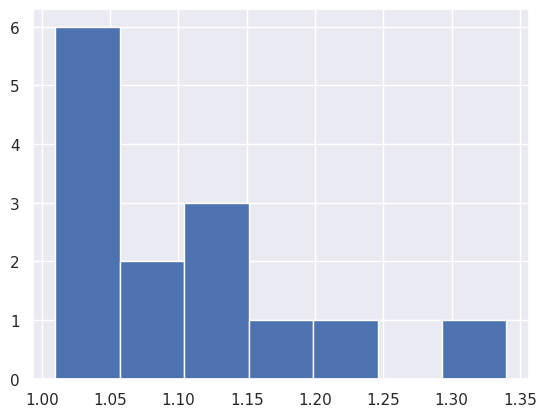

In [308]:
table[table['Отношение_мед'] >= 1]['Отношение_мед'].hist(bins = 7)
print('Среднее:', round((table[(table['Отношение_мед'] >= 1.04) & (table['Отношение_мед'] < 1.18)]['Отношение_мед'].mean() - 1) * 100, 2))
print('Медиана:',  round((table[table['Отношение_мед'] >= 1]['Отношение_мед'].median() - 1) * 100, 2))
#print('Среднее:', (table[table['Отношение_ср'] >= 1]['Отношение_ср'].mean() - 1) * 100)
#print('Медиана:', (table[table['Отношение_ср'] >= 1]['Отношение_ср'].median() - 1) * 100)

In [311]:
df_analog[df_analog['ind_t'] == 0]

,Цена(кв.м),ОПлощадь,Этаж_1,ГП,Терраса,Адрес_yandex,Районы_2_enc,Ремонт_1_enc,ЖК_БД_enc,lat,lon,distances,ind_t
0,252427.184466,103.00,2,2020.0,1.0,"Екатеринбург, Машинная улица, 1В",12,4,1,60.629769,56.815764,0.000000,0
1,195535.714286,112.00,6,2019.0,0.0,"Екатеринбург, улица Ткачей, 17",12,4,1,60.633021,56.816311,0.044006,0
2,202654.867257,113.00,8,2019.0,0.0,"Екатеринбург, улица Ткачей, 17",12,4,1,60.633021,56.816311,0.046687,0
3,233402.489627,96.40,2,2024.0,0.0,"Екатеринбург, Машинная улица, 1В/3",12,4,1,60.632221,56.815030,0.060589,0
4,249840.119378,93.82,2,2024.0,0.0,"Екатеринбург, Машинная улица, 1В/3",12,4,1,60.632221,56.815030,0.067508,0
5,220264.317181,90.80,5,2024.0,0.0,"Екатеринбург, Машинная улица, 1В/3",12,4,1,60.632221,56.815030,0.075607,0


# Функция

In [352]:
df = pd.read_excel('Выборка_ектб.xlsx', sheet_name = 0)

In [353]:
df = df[df['Мусор'] == 0]
df = df[df['Выбросы'] == 0]
df = df[df['dup_res'] == 0]
df = df[df['Многоуровневость'] == 0]
#df = df[df['Терраса'] == 0]
#df = df[df['Вид_1'] == 'нет']
df.reset_index(drop = True , inplace = True)
df['Адрес_yandex'] = df['Адрес_yandex'].str.replace(r'Россия, Свердловская область, ', '', regex = True) # Сокращение адреса

In [354]:
df_sample = df[[
                'Цена(кв.м)',
                'ОПлощадь',
                'Этаж_1',
                'ГП',
                'Ремонт_1',
                'Районы_2',
                'Сцепка_к',
                'ЖК_БД',
                'Терраса',
                'Адрес_yandex'
              ]]
df_sample

,Цена(кв.м),ОПлощадь,Этаж_1,ГП,Ремонт_1,Районы_2,Сцепка_к,ЖК_БД,Терраса,Адрес_yandex
0,99573.257468,70.30,3,2009.0,стандартный,Академический,60.514731 56.810482,нет,0.0,"Екатеринбург, улица Соболева, 19"
1,106435.643564,40.40,4,1960.0,стандартный,Центральный,60.636515 56.826183,нет,0.0,"Екатеринбург, улица Декабристов, 4"
2,124941.065535,42.42,14,2012.0,стандартный,Пионерский,60.648157 56.864782,нет,0.0,"Екатеринбург, Боровая улица, 31"
3,113556.338028,56.80,4,2014.0,стандартный,Уктус,60.681647 56.782174,нет,0.0,"Екатеринбург, Алтайская улица, 62"
4,168552.036199,44.20,6,2016.0,стандартный,Южный,60.616276 56.804894,нет,0.0,"Екатеринбург, улица Степана Разина, 107Ак2"
...,...,...,...,...,...,...,...,...,...,...
7909,141451.612903,31.00,13,2017.0,стандартный,Юго_Западный,60.572447 56.81096,нет,0.0,"Екатеринбург, улица Громова, 26"
7910,99475.065617,38.10,9,1994.0,стандартный,Уктус,60.649271 56.795727,нет,0.0,"Екатеринбург, Просторная улица, 85"
7911,106543.209877,32.40,9,1994.0,стандартный,Уктус,60.649271 56.795727,нет,0.0,"Екатеринбург, Просторная улица, 85"
7912,118902.439024,32.80,6,1994.0,стандартный,Уктус,60.649271 56.795727,нет,0.0,"Екатеринбург, Просторная улица, 85"


In [355]:
lats = []
lons = []

for i in range(len(df_sample['Сцепка_к'])):
    lat = df_sample['Сцепка_к'][i].split(' ')[0]
    lon = df_sample['Сцепка_к'][i].split(' ')[1]
            
    lats.append(lat)
    lons.append(lon)
    
df_sample['lat'] = [float(i) for i in lats]
df_sample['lon'] = [float(i) for i in lons]

/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [394]:
df_sample.columns

Index(['Цена(кв.м)', 'ОПлощадь', 'Этаж_1', 'ГП', 'Ремонт_1', 'Районы_2',
       'Сцепка_к', 'ЖК_БД', 'Терраса', 'Адрес_yandex', 'lat', 'lon'],
      dtype='object')

In [356]:
def get_categorical_indicies(X):
    
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    
    return cats

In [357]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Преобразуем градусы в радианы
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Создаем массив для координат
    coords_1 = np.array([[lat1_rad, lon1_rad]])
    coords_2 = np.array([[lat2_rad, lon2_rad]])
    
    # Вычисляем расстояние
    return haversine_distances(coords_1, coords_2) * 6371000  # Умножаем на радиус Земли в метрах

In [408]:
def distance_graph(data, ind_t = 0, n_neighbors = 5, h = 0.00006):
    '''
    data - набор данных (df_analog) с аналогами, полученный из функции paired_comparisosn.
    ind_t - индекс объекта, для которого анализируем аналоги. По умолчанию выводится 1 ОО.
    n_neighbors - количество ближайших аналогов, по умолчанию 5.    
    h - расстояние подписи точки аналога.
    '''
    fontsize = 11
    
    df_dg = data.copy()
    
    s_1 = df_dg['ind_t'] == ind_t

    plt.figure(figsize = (10, 8))

    # Объекты аналоги
    plt.scatter(df_dg[s_1]['lon'].iloc[1:n_neighbors + 1], df_dg[s_1]['lat'].iloc[1:n_neighbors + 1], color = 'blue', label = 'Объекты-аналоги', alpha = 0.5)
    # Объект оценки
    plt.scatter(df_dg[s_1]['lon'].iloc[0], df_dg[s_1]['lat'].iloc[0], color = 'red', label = 'Объект оценки', s = 100)

    for i in range(len(df_dg[s_1]['lon']) - 1):
        plt.text(df_dg[s_1]['lon'].iloc[i + 1], df_dg[s_1]['lat'].iloc[i + 1] + h, f'{df_dg["metrs"][i + 1]:,.0f}', ha = 'center', va = 'bottom', fontsize = fontsize)

    plt.title('График расстояния объекта оценки от объектов-аналогов (в метрах)')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.legend()
    plt.grid()
    plt.show()

In [401]:
def paired_comparisosn(data, price_col, square_col, filtr, factors, n_neighbors = 5, algorithm = 'ball_tree', metric = 'manhattan', scaler = True):
    '''
    data - набор данных (df), желательно очистить его от лишней информации.
    price_col - столбец с удельной ценой.
    square_col - столбец с площадью.
    filtr - фактор, по которому осуществляется фильтрация (выделяем таблицу с объектами оценки). ОО должен иметь метку 1.
    factors - важные ценообразующие факторы, которые необходимо учесть при поиске аналогов (список).
    n_neighbors - количество ближайших аналогов, по умолчанию 5.
    algorithm - алгоритм поиска ближайших аналогов, по умолчанию ball_tree.
    metric - мера расчета расстояния при поиске ближайших аналогов, по умолчанию manhattan.
    scaler - необходимость в масштабировании, по умолчанию True (MinMaxScaler).
    '''
    df_pc = data.copy()
    df_oo = df_pc[df_pc[filtr] == 1]
    
    indexes_f = df_oo.index.tolist()
    
    if 'lat' not in factors:
        return print('Столбец с широтой должен иметь имя lat. Для переименования столбца используйте функцию df.rename(columns = {"Широта": "lat"})')
    
    if 'lon' not in factors:
        return print('Столбец с долготой должен иметь имя lon. Для переименования столбца используйте функцию df.rename(columns = {"Долгота": "lon"})')
    
    df_factors = df_pc[factors]
    
    cats = get_categorical_indicies(df_factors)
    if cats:
        le = LabelEncoder()
        for cat in cats:
            df_factors[f'{cat}_enc'] = le.fit_transform(df_factors[cat])
            df_factors = df_factors.drop([cat], axis = 1)
    
    if scaler == True:
        scaler = MinMaxScaler()
        df_factors_scale = scaler.fit_transform(df_factors)
    else:
        df_factors_scale = df_factors
    
    table = []

    for i in tqdm(range(0, len(indexes_f), 1), total = len(indexes_f), position = 0):

        indexes_f = df_oo.index.tolist()
        df_factors_scale_drop = df_factors_scale.copy()
        df_pc_drop = df_pc.copy()

        ind = indexes_f.pop(i)

        df_factors_scale_drop = np.delete(df_factors_scale_drop, indexes_f, axis = 0)

        df_pc_drop = df_pc_drop.drop(indexes_f)
        df_pc_drop.reset_index(drop = True , inplace = True)

        knn = NearestNeighbors(
                               n_neighbors = n_neighbors + 1,
                               algorithm = algorithm,
                               metric = metric
                              )

        knn.fit(df_factors_scale_drop)

        distances, neighbors_indices = knn.kneighbors(df_factors_scale_drop)

        sim = df_pc_drop.loc[neighbors_indices[ind - i]] #.drop(index = ind - i, axis = 0)
        sim['distances'] = distances[ind - i]
        sim['ind_t'] = i
        
        #print(sim)
        
        metrs = []
        for j in range(len(sim)):
            metrs.append(round(calculate_distance(sim['lat'].iloc[0], sim['lon'].iloc[0], sim['lat'].iloc[j], sim['lon'].iloc[j])[0][0], 0))
            
        sim['metrs'] = metrs

        if i == 0:
            df_analog = sim
        else:
            df_analog = pd.concat([df_analog, sim], ignore_index = True)

        sim = sim.drop(index = ind - i, axis = 0)     
        price_oo = df_pc_drop.loc[neighbors_indices[ind - i]].loc[ind - i:ind - i, price_col].values[0]
        square_oo = df_pc_drop.loc[neighbors_indices[ind - i]].loc[ind - i:ind - i, square_col].values[0]
        # price_oo = sim.loc[ind - i:ind - i, 'Цена(кв.м)'].values[0]
        # square_oo = sim.loc[ind - i:ind - i, 'ОПлощадь'].values[0]

        pc = {
              'Цена_оо': price_oo,
              'Площадь': square_oo,
              'Среднее': round(sim['Цена(кв.м)'].mean(), 0),
              'Медиана': round(sim['Цена(кв.м)'].median(), 0),
              'Мин': round(sim['Цена(кв.м)'].min(), 0),
              'Макс': round(sim['Цена(кв.м)'].max(), 0),
              'Отношение_ср': round(price_oo / sim['Цена(кв.м)'].mean(), 2),
              'Отношение_мед': round(price_oo / sim['Цена(кв.м)'].median(), 2)
             }

        table.append(pc)

    table = pd.DataFrame(table)
    
    return table, df_analog

In [402]:
table, df_analog = paired_comparisosn(data = df_sample,
                                      price_col = 'Цена(кв.м)',
                                      square_col = 'ОПлощадь',
                                      filtr = 'Терраса',
                                      factors = ['ОПлощадь', 'ГП', 'Ремонт_1', 'ЖК_БД', 'lat', 'lon'],
                                      )

/opt/conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


In [403]:
table

,Цена_оо,Площадь,Среднее,Медиана,Мин,Макс,Отношение_ср,Отношение_мед
0,252427.184466,103.0,220340.0,220264.0,195536.0,249840.0,1.15,1.15
1,144944.444444,180.0,140679.0,153850.0,90686.0,162659.0,1.03,0.94
2,138297.872340,47.0,182459.0,187173.0,154661.0,199115.0,0.76,0.74
3,160337.224384,77.1,174139.0,157895.0,153896.0,214286.0,0.92,1.02
4,162475.000000,40.0,151823.0,147005.0,132500.0,178947.0,1.07,1.11
5,125859.375000,115.2,109882.0,106280.0,93799.0,132599.0,1.15,1.18
6,159716.060337,112.7,174504.0,177778.0,145950.0,189599.0,0.92,0.90
7,140897.435897,78.0,134515.0,124271.0,119828.0,162791.0,1.05,1.13
8,259451.445515,134.9,273552.0,250184.0,228137.0,343210.0,0.95,1.04
9,125454.545455,55.0,118202.0,115000.0,113636.0,128250.0,1.06,1.09


In [406]:
df_analog[df_analog['ind_t'] == 0]

,Цена(кв.м),ОПлощадь,Этаж_1,ГП,Ремонт_1,Районы_2,Сцепка_к,ЖК_БД,Терраса,Адрес_yandex,lat,lon,distances,ind_t,metrs
0,252427.184466,103.00,2,2020.0,требует_косметического_ремонта,Клевер_Парк,60.629769 56.815764,престижный,1.0,"Екатеринбург, Машинная улица, 1В",60.629769,56.815764,0.000000,0,0.0
1,195535.714286,112.00,6,2019.0,требует_косметического_ремонта,Клевер_Парк,60.633021 56.816311,престижный,0.0,"Екатеринбург, улица Ткачей, 17",60.633021,56.816311,0.044006,0,363.0
2,202654.867257,113.00,8,2019.0,требует_косметического_ремонта,Клевер_Парк,60.633021 56.816311,престижный,0.0,"Екатеринбург, улица Ткачей, 17",60.633021,56.816311,0.046687,0,363.0
3,233402.489627,96.40,2,2024.0,требует_косметического_ремонта,Клевер_Парк,60.632221 56.81503,престижный,0.0,"Екатеринбург, Машинная улица, 1В/3",60.632221,56.815030,0.060589,0,276.0
4,249840.119378,93.82,2,2024.0,требует_косметического_ремонта,Клевер_Парк,60.632221 56.81503,престижный,0.0,"Екатеринбург, Машинная улица, 1В/3",60.632221,56.815030,0.067508,0,276.0
5,220264.317181,90.80,5,2024.0,требует_косметического_ремонта,Клевер_Парк,60.632221 56.81503,престижный,0.0,"Екатеринбург, Машинная улица, 1В/3",60.632221,56.815030,0.075607,0,276.0


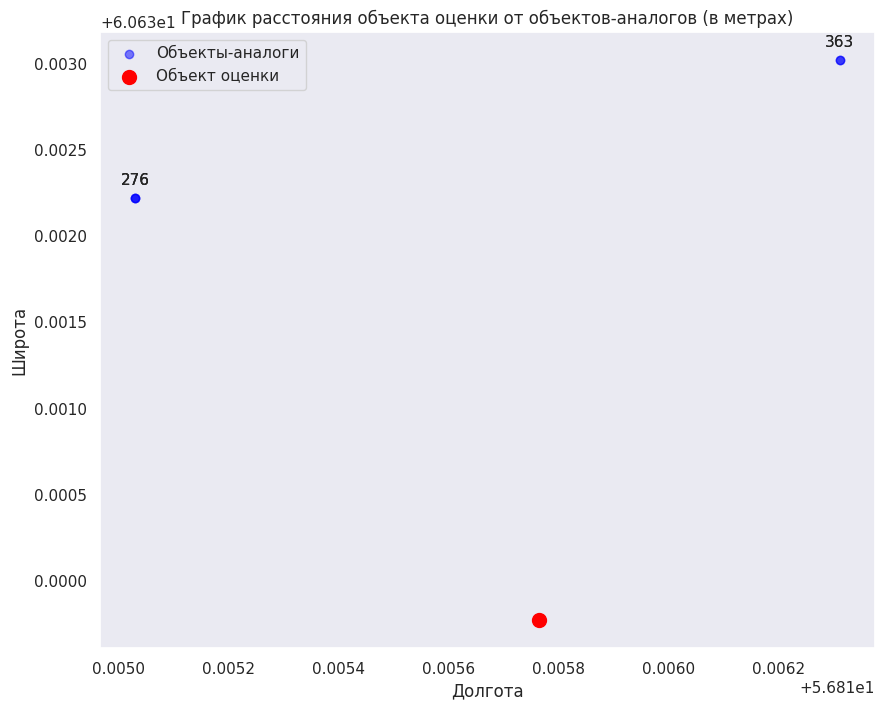

In [409]:
distance_graph(
               data = df_analog, 
               ind_t = 0, 
               n_neighbors = 5, 
               h = 0.00006
              )